In [ ]:
%%capture
!pip install datasets
!pip install transformers

In [ ]:
%%capture
import re
from transformers import GPT2LMHeadModel, GPT2TokenizerFast
from torch.utils.data import DataLoader
import torch
import torch.nn as nn
from datasets import Dataset as ds
from torch.utils.data import Dataset
import pandas as pd
from torch.optim import Adam
from tqdm.auto import tqdm

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
device = torch.device("cuda:0")
print(device)

cuda:0


In [ ]:
# Import necessary libraries
from tensorflow.python.client import device_lib

# Get the GPU device name
device_lib.list_local_devices()

[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 11373803391263283052
 xla_global_id: -1,
 name: "/device:GPU:0"
 device_type: "GPU"
 memory_limit: 14410383360
 locality {
   bus_id: 1
   links {
   }
 }
 incarnation: 12581340454771867573
 physical_device_desc: "device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5"
 xla_global_id: 416903419]

In [ ]:
import csv
cnn_dataset = {'train': {}, 'test': {}, 'validation':{}}

train_csv_file = r"/content/gdrive/MyDrive/nlp dataset/archive/cnn_dailymail/train.csv"
test_csv_file = r"/content/gdrive/MyDrive/nlp dataset/archive/cnn_dailymail/test.csv"
val_csv_file = r"/content/gdrive/MyDrive/nlp dataset/archive/cnn_dailymail/validation.csv"

# Function to load data from a CSV file into the dataset
def load_data(csv_file, split):
  with open(csv_file, mode='r', encoding='utf-8') as file:
    csv_reader = csv.DictReader(file)

    id_list = []
    article_list = []
    highlights_list = []

    for row in csv_reader:
      id = row['id']
      article = row['article']
      highlights = row['highlights']

      id_list.append(id)
      article_list.append(article)
      highlights_list.append(highlights)

    if(split=='train'):
      cnn_dataset[split]['id'] = id_list
      cnn_dataset[split]['article'] = article_list
      cnn_dataset[split]['highlights'] = highlights_list

      cnn_dataset[split]['id'] = cnn_dataset[split]['id'][:2871]
      cnn_dataset[split]['article'] = cnn_dataset[split]['article'][:2871]
      cnn_dataset[split]['highlights'] = cnn_dataset[split]['highlights'][:2871]

    elif(split=='test'):
      cnn_dataset[split]['id'] = id_list
      cnn_dataset[split]['article'] = article_list
      cnn_dataset[split]['highlights'] = highlights_list

      cnn_dataset[split]['id'] = cnn_dataset[split]['id'][:114]
      cnn_dataset[split]['article'] = cnn_dataset[split]['article'][:114]
      cnn_dataset[split]['highlights'] = cnn_dataset[split]['highlights'][:114]

    elif(split=='validation'):
      cnn_dataset[split]['id'] = id_list
      cnn_dataset[split]['article'] = article_list
      cnn_dataset[split]['highlights'] = highlights_list

      cnn_dataset[split]['id'] = cnn_dataset[split]['id'][:133]
      cnn_dataset[split]['article'] = cnn_dataset[split]['article'][:133]
      cnn_dataset[split]['highlights'] = cnn_dataset[split]['highlights'][:133]

# Load train data
load_data(train_csv_file, 'train')

# Load test data
load_data(test_csv_file, 'test')

# Load val data
load_data(val_csv_file, 'validation')

In [ ]:
cnn_dataset.keys()

dict_keys(['train', 'test', 'validation'])

In [ ]:
class SoftEmbedding(nn.Module):
  def __init__(self, wte: nn.Embedding, n_tokens: int = 10, random_range: float = 0.5, initialize_from_vocab: bool = True):
      super(SoftEmbedding, self).__init__()
      self.wte = wte
      self.n_tokens = n_tokens
      self.learned_embedding = nn.parameter.Parameter(self.initialize_embedding(wte, n_tokens, random_range, initialize_from_vocab))

  def initialize_embedding(self,
                            wte: nn.Embedding,
                            n_tokens: int = 10,
                            random_range: float = 0.5, initialize_from_vocab: bool = True):
      if initialize_from_vocab:
          return self.wte.weight[:n_tokens].clone().detach()
      return torch.FloatTensor(n_tokens, wte.weight.size(1)).uniform_(-random_range, random_range)

  def forward(self, tokens):
      input_embedding = self.wte(tokens[:, self.n_tokens:])
      learned_embedding = self.learned_embedding.repeat(input_embedding.size(0), 1, 1)
      return torch.cat([learned_embedding, input_embedding], 1)

In [ ]:
model = GPT2LMHeadModel.from_pretrained('gpt2')
tokenizer = GPT2TokenizerFast.from_pretrained("gpt2")

tokenizer.add_special_tokens({"pad_token": "<pad>",
                              "bos_token": "<sos>",
                              "eos_token": "<eos>"
                             })
model.config.pad_token_id = tokenizer.pad_token_id
model.config.bos_token_id = tokenizer.bos_token_id
model.config.eos_token_id = tokenizer.eos_token_id

tokenizer.add_tokens(["<extract>"])
model.resize_token_embeddings(len(tokenizer))

n_tokens = 1

s_wte = SoftEmbedding(model.get_input_embeddings(), n_tokens=n_tokens, initialize_from_vocab=True)
model.set_input_embeddings(s_wte)

if torch.cuda.is_available():
    model = model.cuda()

(…)ingface.co/gpt2/resolve/main/config.json:   0%|          | 0.00/665 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/548M [00:00<?, ?B/s]

(…)gpt2/resolve/main/generation_config.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

(…)gingface.co/gpt2/resolve/main/vocab.json:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

(…)gingface.co/gpt2/resolve/main/merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

(…)face.co/gpt2/resolve/main/tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

Dataset Class

In [ ]:
val = tokenizer("Grand Forks and Jamestown to the hepatitis A virus", max_length=20, truncation=True, padding="max_length", return_tensors="pt")

print(val.keys())

print(val["input_ids"])
print(val["attention_mask"])

dict_keys(['input_ids', 'attention_mask'])
tensor([[  464, 24233,   286,   262, 28125,  7835,  6031, 31292,   287,  2258,
         13336,   468,  7362,   220, 50257, 50257, 50257, 50257, 50257, 50257]])
tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0]])


In [ ]:
model

GPT2LMHeadModel(
  (transformer): GPT2Model(
    (wte): SoftEmbedding(
      (wte): Embedding(50261, 768)
    )
    (wpe): Embedding(1024, 768)
    (drop): Dropout(p=0.1, inplace=False)
    (h): ModuleList(
      (0-11): 12 x GPT2Block(
        (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (attn): GPT2Attention(
          (c_attn): Conv1D()
          (c_proj): Conv1D()
          (attn_dropout): Dropout(p=0.1, inplace=False)
          (resid_dropout): Dropout(p=0.1, inplace=False)
        )
        (ln_2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (mlp): GPT2MLP(
          (c_fc): Conv1D()
          (c_proj): Conv1D()
          (act): NewGELUActivation()
          (dropout): Dropout(p=0.1, inplace=False)
        )
      )
    )
    (ln_f): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
  )
  (lm_head): Linear(in_features=768, out_features=50261, bias=False)
)

In [ ]:
class SummaryDataset(Dataset):
  def __init__(self, cnn_dataset, tokenizer):
    self.data = cnn_dataset
    self.article = self.data['article']
    self.highlights = self.data['highlights']

    self.X = []

    for article, highlights in zip(self.article, self.highlights):
        self.X.append("<sos> " + article + " <extract> " + " ".join(highlights.split("\n")).strip() + " <eos>")

    # print(self.X[0])
    # print("="*80)
    # print(self.article[0])
    # print("="*80)
    # print(" ".join(self.highlights[0].split("\n")))
    # print("="*80)

    self.encode = tokenizer(self.X, max_length=1023, truncation=True, padding="max_length", return_tensors="pt")
    # self.encode = torch.cat([torch.full((1,n_tokens), 50261), self.encode], 1)
    self.attention_mask = self.encode['attention_mask']
    self.input_ids = self.encode['input_ids']
    # self.attention_mask = torch.cat([torch.full((1,n_tokens), 1), self.attention_mask], 1)

    # print("len(self.encode)", len(self.encode))
    # print(self.X[0])

  def __len__(self):
    return len(self.X)

  def __getitem__(self, idx):
    return (self.input_ids[idx], self.attention_mask[idx])

In [ ]:
dataset = SummaryDataset(cnn_dataset['train'], tokenizer)

In [ ]:
batch_size = 1

dataloader = DataLoader(dataset, batch_size=batch_size)

In [ ]:
dataset_val = SummaryDataset(cnn_dataset['test'], tokenizer)
dataloader_val = DataLoader(dataset_val, batch_size=batch_size)


In [ ]:
for batch in dataloader:
    print(len(batch[0][0]), batch[0][0])
    print(len(batch[1][0]), torch.sum(batch[1][0]), batch[1][0])
    break

1023 tensor([50258,  2750,   764,  ..., 50257, 50257, 50257])
1023 tensor(291) tensor([1, 1, 1,  ..., 0, 0, 0])


Training Loop

In [ ]:
optim = Adam(model.parameters(), lr=1e-3)

In [ ]:
device

device(type='cuda', index=0)

In [ ]:
parameters = list(model.parameters())
for x in parameters[1:]:
    x.requires_grad = False

In [ ]:
epochs = 2
total_loss = 0
num_batches = 0
losses = []
rouges = []

for epoch in range(epochs):
    for ques, ans in tqdm(dataloader):
        ques = torch.cat([torch.full((1, n_tokens), 0, dtype=torch.long), ques], 1)
        ans = torch.cat([torch.full((1, n_tokens), 0, dtype=torch.long), ans], 1)

        ques = ques.to(device)
        ans = ans.to(device)

        optim.zero_grad()
        outputs = model(ques, attention_mask=ans, labels=ques)
        loss = outputs.loss
        # print(loss)
        loss.backward()
        optim.step()

        total_loss += loss.item()
        num_batches += 1
        losses.append(loss.item() / batch_size)
    avg_loss = total_loss / num_batches
    print(f'Epoch: {epoch+1}, Loss: {avg_loss:.4f}')
    if avg_loss <= 0.155:
        model.save_pretrained('gpt2_cnn_daily')


    val_loss = 0
    num_batches = 0
    for ques, ans in tqdm(dataloader_val):
        ques = torch.cat([torch.full((1, n_tokens), 0, dtype=torch.long), ques], 1)
        ans = torch.cat([torch.full((1, n_tokens), 0, dtype=torch.long), ans], 1)

        ques = ques.to(device)
        ans = ans.to(device)

        optim.zero_grad()
        outputs = model(ques, attention_mask=ans, labels=ques)
        loss = outputs.loss
        optim.step()

        val_loss += loss.item()
        num_batches += 1
        # losses.append(loss.item() / batch_size)
    avg_loss = val_loss / num_batches
    print(f'Epoch: {epoch+1}, VAL Loss: {avg_loss:.4f}')


  0%|          | 0/2871 [00:00<?, ?it/s]

Epoch: 1, Loss: 2.7364


  0%|          | 0/114 [00:00<?, ?it/s]

Epoch: 1, VAL Loss: 2.6589


  0%|          | 0/2871 [00:00<?, ?it/s]

Epoch: 2, Loss: 5.0371


  0%|          | 0/114 [00:00<?, ?it/s]

Epoch: 2, VAL Loss: 2.9628


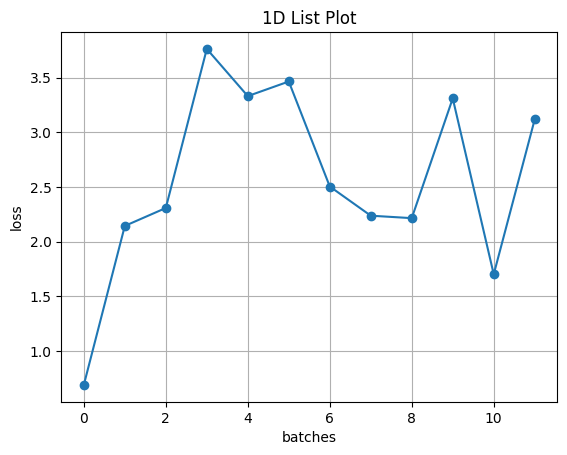

In [ ]:
import matplotlib.pyplot as plt

# Example data (replace with your actual data)
# result = [10, 15, 20, 18, 25]

# Plot the data
plt.plot(losses[::500], marker='o')
plt.xlabel('batches')
plt.ylabel('loss')
plt.title('1D List Plot')
plt.grid(True)
plt.show()


In [ ]:
epochs = 1
total_loss = 0
num_batches = 0
losses = []
rouges = []
optim = Adam(model.parameters(), lr=1e-1)

model = model.to('cuda')
for epoch in range(epochs):
    for ques, ans in tqdm(dataloader):
        ques = torch.cat([torch.full((1, n_tokens), 0, dtype=torch.long), ques], 1)
        ans = torch.cat([torch.full((1, n_tokens), 0, dtype=torch.long), ans], 1)

        ques = ques.to(device)
        ans = ans.to(device)

        optim.zero_grad()
        outputs = model(ques, attention_mask=ans, labels=ques)
        loss = outputs.loss
        # print(loss)
        loss.backward()
        optim.step()

        total_loss += loss.item()
        num_batches += 1
        losses.append(loss.item() / batch_size)
    avg_loss = total_loss / num_batches
    print(f'Epoch: {epoch+1}, Loss: {avg_loss:.4f}')
    if avg_loss <= 0.155:
        model.save_pretrained('gpt2_cnn_daily')


    val_loss = 0
    num_batches = 0
    for ques, ans in tqdm(dataloader_val):
        ques = torch.cat([torch.full((1, n_tokens), 0, dtype=torch.long), ques], 1)
        ans = torch.cat([torch.full((1, n_tokens), 0, dtype=torch.long), ans], 1)

        ques = ques.to(device)
        ans = ans.to(device)

        optim.zero_grad()
        outputs = model(ques, attention_mask=ans, labels=ques)
        loss = outputs.loss
        optim.step()

        val_loss += loss.item()
        num_batches += 1
        # losses.append(loss.item() / batch_size)
    avg_loss = val_loss / num_batches
    print(f'Epoch: {epoch+1}, VAL Loss: {avg_loss:.4f}')


  0%|          | 0/2871 [00:00<?, ?it/s]

Epoch: 1, Loss: 2.2124


  0%|          | 0/114 [00:00<?, ?it/s]

Epoch: 1, VAL Loss: 2.9628


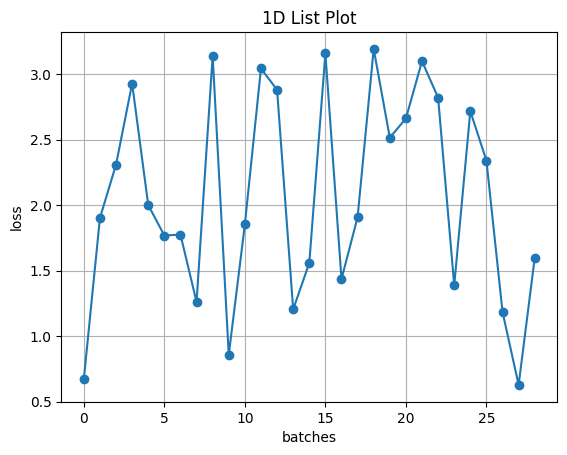

In [ ]:
import matplotlib.pyplot as plt

# Example data (replace with your actual data)
# result = [10, 15, 20, 18, 25]

# Plot the data
plt.plot(losses[::100], marker='o')
plt.xlabel('batches')
plt.ylabel('loss')
plt.title('1D List Plot')
plt.grid(True)
plt.show()


In [ ]:
trained_parameter = parameters[0]

In [ ]:
model

GPT2LMHeadModel(
  (transformer): GPT2Model(
    (wte): SoftEmbedding(
      (wte): Embedding(50261, 768)
    )
    (wpe): Embedding(1024, 768)
    (drop): Dropout(p=0.1, inplace=False)
    (h): ModuleList(
      (0-11): 12 x GPT2Block(
        (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (attn): GPT2Attention(
          (c_attn): Conv1D()
          (c_proj): Conv1D()
          (attn_dropout): Dropout(p=0.1, inplace=False)
          (resid_dropout): Dropout(p=0.1, inplace=False)
        )
        (ln_2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (mlp): GPT2MLP(
          (c_fc): Conv1D()
          (c_proj): Conv1D()
          (act): NewGELUActivation()
          (dropout): Dropout(p=0.1, inplace=False)
        )
      )
    )
    (ln_f): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
  )
  (lm_head): Linear(in_features=768, out_features=50261, bias=False)
)

In [ ]:
model.save_pretrained("/content/gdrive/MyDrive/nlp dataset/gpt2_abstractive_extractive.pth")

In [ ]:
no_of_parameters = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(no_of_parameters)

768


In [ ]:
trained_parameter

Parameter containing:
tensor([[-9.7878e-02, -3.2619e-02,  3.3416e-02, -1.9975e-01, -1.3399e-01,
          3.3082e-02, -1.1300e-01,  6.5112e-02,  9.3641e-03,  2.7651e-02,
         -4.1214e-01, -1.7346e-01,  1.2814e-01, -3.4314e-01,  4.6551e-01,
          1.3660e-01,  4.8109e-02,  2.3741e-01,  7.5163e-02,  1.7676e-01,
          2.3762e-01, -1.0140e-01, -3.3852e-01, -8.5142e-02, -2.8725e-01,
         -2.7402e-01, -3.2839e-02, -2.4393e-01, -9.1434e-02, -2.0840e-01,
         -3.5608e-02, -2.4856e-01, -2.5158e-01,  2.1413e-01,  4.0668e-01,
         -1.7039e-02, -1.3986e-01, -9.5090e-02, -1.8171e-01, -1.2011e-01,
         -1.4499e-01, -7.4398e-02, -3.1634e-02,  2.2350e-01,  1.1168e-01,
          4.7668e-01, -1.4929e-01,  8.1560e-02,  5.3272e-02, -2.3799e-01,
         -1.3444e-01,  9.5046e-02, -1.2365e-01, -6.1743e-02, -1.8964e-01,
         -4.5108e-01, -9.6189e-02,  1.4509e-01,  4.0695e-02,  2.4415e-01,
         -1.4450e-01,  6.9593e-02, -1.1964e-02, -9.0556e-02,  1.5406e-01,
         -3.1786

In [ ]:
def inference(input_text, model):
    model = model.to('cpu')
    input_ids = tokenizer.encode(input_text, return_tensors='pt')
    ques = torch.cat([torch.full((1, n_tokens), 0, dtype=torch.long), input_ids], 1)
    # print(input_ids)
    output_ids = model.generate(input_ids, max_length=200, num_beams=5, no_repeat_ngram_size=2, top_k=50)
    output_ids = output_ids
    output_text = tokenizer.decode(output_ids[0], skip_special_tokens=True)
    return output_text

In [ ]:
text = """The bishop of the Fargo Catholic Diocese in North Dakota has exposed potentially h
undreds of church members in Fargo, Grand Forks and Jamestown to the hepatitis A vi
rus in late September and early October"""

inference(text, model)

"The bishop of the Fargo Catholic Diocese in North Dakota has exposed potentially h\nundreds of church members in Fargo, Grand Forks and Jamestown to the hepatitis A vi\nrus in late September and early October. Aid has's has has, has is has and,, is, and and.,.. Di. and.. as.., as, Di and Di, from. -. The. . in. M.-.:. An. from, The,,-, -, in, M,:, to. Ep. who. A.'s. Kill. He. Dol. (. U. to,'s,. and The and  and: and as and - and in Di Di: Di as Di   Di in and M and- and Kill, Van. Keane. T. Mush. Van, Keane, Mal. David. F. Mal, He, T, David, Mush, (, Kill and Keane"

In [ ]:
from nltk.translate.bleu_score import sentence_bleu

def find_bleu(reference_tokens, candidate_tokens):
    print("required : ", reference_tokens)
    print("Predicted : ", candidate_tokens)
    mini = min(len(candidate_tokens.split()), len(reference_tokens.split()))
    reference_tokens = [token.lower() for token in reference_tokens.split()][:mini]
    candidate_tokens = [token.lower() for token in candidate_tokens.split()][:mini]

    # Calculate BLEU score
    bleu_score = sentence_bleu([reference_tokens], candidate_tokens)

    # Print the BLEU score
    print("BLEU Score:", bleu_score)


In [ ]:

find_bleu(cnn_dataset['test']['article'][0], inference(cnn_dataset['test']['highlights'][0], model))

required :  Ever noticed how plane seats appear to be getting smaller and smaller? With increasing numbers of people taking to the skies, some experts are questioning if having such packed out planes is putting passengers at risk. They say that the shrinking space on aeroplanes is not only uncomfortable - it's putting our health and safety in danger. More than squabbling over the arm rest, shrinking space on planes putting our health and safety in danger? This week, a U.S consumer advisory group set up by the Department of Transportation said at a public hearing that while the government is happy to set standards for animals flying on planes, it doesn't stipulate a minimum amount of space for humans. 'In a world where animals have more rights to space and food than humans,' said Charlie Leocha, consumer representative on the committee. 'It is time that the DOT and FAA take a stand for humane treatment of passengers.' But could crowding on planes lead to more serious issues than fightin

In [ ]:

find_bleu(cnn_dataset['test']['article'][1], inference(cnn_dataset['test']['highlights'][1], model))

required :  A drunk teenage boy had to be rescued by security after jumping into a lions' enclosure at a zoo in western India. Rahul Kumar, 17, clambered over the enclosure fence at the Kamla Nehru Zoological Park in Ahmedabad, and began running towards the animals, shouting he would 'kill them'. Mr Kumar explained afterwards that he was drunk and 'thought I'd stand a good chance' against the predators. Next level drunk: Intoxicated Rahul Kumar, 17, climbed into the lions' enclosure at a zoo in Ahmedabad and began running towards the animals shouting 'Today I kill a lion!' Mr Kumar had been sitting near the enclosure when he suddenly made a dash for the lions, surprising zoo security. The intoxicated teenager ran towards the lions, shouting: 'Today I kill a lion or a lion kills me!' A zoo spokesman said: 'Guards had earlier spotted him close to the enclosure but had no idea he was planing to enter it. 'Fortunately, there are eight moats to cross before getting to where the lions usuall

In [ ]:

find_bleu(cnn_dataset['test']['article'][2], inference(cnn_dataset['test']['highlights'][2], model))

required :  Dougie Freedman is on the verge of agreeing a new two-year deal to remain at Nottingham Forest. Freedman has stabilised Forest since he replaced cult hero Stuart Pearce and the club's owners are pleased with the job he has done at the City Ground. Dougie Freedman is set to sign a new deal at Nottingham Forest . Freedman has impressed at the City Ground since replacing Stuart Pearce in February . They made an audacious attempt on the play-off places when Freedman replaced Pearce but have tailed off in recent weeks. That has not prevented Forest's ownership making moves to secure Freedman on a contract for the next two seasons.
Predicted :  Nottingham Forest are close to extending Dougie Freedman's contract.
The Forest boss took over from former manager Stuart Pearce in February.
Freedman has since lead the club to ninth in the Championship. The has has's has is has,.. and. from. Keane.-. in. F. Wal.:. Mal. as. Ward. T., and,, Keane, F, Mal,-, Ward, -. ... who. Dol. Park. to.

/usr/local/lib/python3.10/dist-packages/nltk/translate/bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)


In [ ]:
for i in range(40):
    find_bleu(cnn_dataset['test']['article'][i], inference(cnn_dataset['test']['highlights'][i], model))
    print("="*20)


required :  Ever noticed how plane seats appear to be getting smaller and smaller? With increasing numbers of people taking to the skies, some experts are questioning if having such packed out planes is putting passengers at risk. They say that the shrinking space on aeroplanes is not only uncomfortable - it's putting our health and safety in danger. More than squabbling over the arm rest, shrinking space on planes putting our health and safety in danger? This week, a U.S consumer advisory group set up by the Department of Transportation said at a public hearing that while the government is happy to set standards for animals flying on planes, it doesn't stipulate a minimum amount of space for humans. 'In a world where animals have more rights to space and food than humans,' said Charlie Leocha, consumer representative on the committee. 'It is time that the DOT and FAA take a stand for humane treatment of passengers.' But could crowding on planes lead to more serious issues than fightin